In [37]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DS Patient Matching Exploration

In [38]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_rec_hrs_modelling_w_claims_20221109.csv', low_memory=False)
df.head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,glaucoma_ddos,cataract_ddos,behavioral_health_ddos,osteoporosis_ddos,hiv_ddos,transplants_ddos,obesity_ddos,cancer_ddos,hip_pelvic_fracture_ddos,sclerosis_ddos,rheumatoid_arthritis_ddos,ckd_ddos,hyperlipidemia_ddos,diabetes_ddos,hypothyroidism_ddos,pressure_ulcer_ddos,weight_loss_ddos,heart_ddos,peptic_ulcer_ddos,anemia_ddos,substance_abuse_ddos,liver_ddos,disabled_ddos,fall_ddos,stroke_ddos,paralysis_ddos,hypertension_ddos,peripheral_vascular_ddos,coagulation_ddos,fluid_ddos,benign_prostatic_hyperplasia_ddos,tbi_ddos,neurocognitive_ddos,pulmonary_ddos,glaucoma_tc,cataract_tc,behavioral_health_tc,osteoporosis_tc,hiv_tc,transplants_tc,obesity_tc,cancer_tc,hip_pelvic_fracture_tc,sclerosis_tc,rheumatoid_arthritis_tc,ckd_tc,hyperlipidemia_tc,diabetes_tc,hypothyroidism_tc,pressure_ulcer_tc,weight_loss_tc,heart_tc,peptic_ulcer_tc,anemia_tc,substance_abuse_tc,liver_tc,disabled_tc,fall_tc,stroke_tc,paralysis_tc,hypertension_tc,peripheral_vascular_tc,coagulation_tc,fluid_tc,benign_prostatic_hyperplasia_tc,tbi_tc,neurocognitive_tc,pulmonary_tc
0,2,1,3167,33,29,16,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,True,NaN,occasional_incontinence,NaN,2,1,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,False,Maria Plunkett,30.0,25.0,2020-12-20 15:26:06.000000,False,84,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,10.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,62.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1154.87,3422.46,0.0,0.00,0.00,6347.46,0.0,163.51,0.0,0.0,0.0,84.76,129.71,0.00,939.89,3218.26,0.0,0.00,0.0,0.0,0.00,0.00
1,2,1,3167,6254,19,14,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,False,NaN,NaN,NaN,1,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Lenahan,15.0,15.0,2021-12-29 20:51:41.070885,False,84,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,14.0,0.0,2.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,49.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,250.88,135.16,1252.28,0.0,139.80,126.89,3083.94,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,499.63,1221.50,0.0,68.35,0.0,0.0,0.00,0.00
2,2,2,3678,131,29,19,3.0,3.0,3.0,2.0,3.0,0.0,2.0,3.0,True,NaN,always_incontinent,NaN,0,0,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,False,Maria Plunkett,48.0,40.0,2021-01-12 23:58:03.877177,False,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,14.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.61,0.00,44.29,1052.48,0.0,34.44,0.00,0.00,0.0,409.55,0.0,0.0,0.0,0.00,0.00,0.00,1227.56,0.00,0.0,0.00,0.0,0.0,746.83,55.14
3,2,2,3678,9489,26,22,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,1,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,False,Katy Slaven,48.0,48.0,2022-01-27 18:56:10.709471,False,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,9.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2261.85,8.91,268.20,0.0,68.34,2095.43,68.34,0.0,0.00,0.0,0.0,0.0,0.00,392.44,0.00,1275.47,0.00,0.0,0.00,0.0,0.0,2560.14,105.42
4,2,4,3653,6360,26,14,2.0,2.0,2.0,2.0,2.0

### Modeling

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [55]:
categorical_features = [
    # slight boost
    'alert_oriented_self',
    'alert_oriented_place',
    'alert_oriented_day_time',

    # did not show any lift, low feature importance
    # 'has_incontinence',
    # 'incontinence_type',
    # 'incontinence_frequency',
]

cont_features = [
    # 'reporting_current_hrs',
    'payer_id',
    
    ## claim based
    # 'glaucoma_ddos',
    # 'cataract_ddos',
    # 'behavioral_health_ddos',
    # 'osteoporosis_ddos',
    # 'hiv_ddos',
    'transplants_ddos',
    # 'obesity_ddos',
    'cancer_ddos',
    'hip_pelvic_fracture_ddos',
    # 'sclerosis_ddos',
    # 'rheumatoid_arthritis_ddos',
    'ckd_ddos',
    # 'hyperlipidemia_ddos',
    # 'diabetes_ddos',
    # 'hypothyroidism_ddos',
    # 'pressure_ulcer_ddos',
    # 'weight_loss_ddos',
    'heart_ddos',
    # 'peptic_ulcer_ddos',
    # 'anemia_ddos',
    # 'substance_abuse_ddos',
    'liver_ddos',
    # 'disabled_ddos',
    'fall_ddos',
    'stroke_ddos',
    'paralysis_ddos',
    # 'hypertension_ddos',
    # 'peripheral_vascular_ddos',
    # 'coagulation_ddos',
    # 'fluid_ddos',
    # 'benign_prostatic_hyperplasia_ddos',
    'tbi_ddos',
    'neurocognitive_ddos',
    'pulmonary_ddos',
    ## end claim based
    
    'age',
    # adls
    'transfer_bed_to_chair',
    'transfer_chair_to_standing',
    'mobility',
    'dressing',
    'bathing',
    'eating',
    'grooming',
    'toileting',
    'turn_change_position',
    # idls
    'calling_friends_and_family',
    'articulating_needs',
    'meal_prep',
    'shopping',
    'medication_management',
    'finances',
    'housework',
    'transportation',
    'driving',
    'daily_routine_decisions',
    'comprehension',
    'member_opinion',
    'cleaning',
    'laundry',
    'change_bed',
    'clean_kitchen',
    'clean_home',
    'medical_appointments',
    'work_school_socialize'
]
features = categorical_features + cont_features
target = 'reporting_rec_hrs'
# leave out payer id to keep it interpretable
categorical_feature_indexes = [i for i in range(len(categorical_features))] + [len(categorical_features)]

In [56]:
# encode_cat_features: HGBR requires categorical features to be 0-n_categories encoded
from sklearn.preprocessing import OrdinalEncoder
df[categorical_features] = OrdinalEncoder().fit_transform(df[categorical_features])

In [57]:
len(features)

45

In [58]:
df[features].head()

,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,payer_id,transplants_ddos,cancer_ddos,hip_pelvic_fracture_ddos,ckd_ddos,heart_ddos,liver_ddos,fall_ddos,stroke_ddos,paralysis_ddos,tbi_ddos,neurocognitive_ddos,pulmonary_ddos,age,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize
0,1.0,1.0,0.0,2,0.0,0.0,0.0,0.0,15.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,84,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2,1,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,2,0.0,0.0,0.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,NaN,1,0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,75,3.0,3.0,3.0,2.0,3.0,0.0,2.0,3.0,NaN,0,0,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,0.0,2,0.0,0.0,0.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,10.0,1.0,75,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0,NaN,0,1,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,52,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,NaN,0,0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### All assessor model

In [92]:
# use same test set as previously
test_sfere_ids = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/sfere_og_test_set.csv', low_memory=False)
test_sfere_ids.head()

,sfere_id
0,28800
1,30479
2,28008
3,28682
4,31076


In [97]:
all_assessor_ds = ds_matching.tt_split_by_sfere_ids(df, features=features, target=target, test_sfere_ids=test_sfere_ids.sfere_id)
all_assessor_ds.x_train.shape, all_assessor_ds.x_test.shape, all_assessor_ds.training_df.shape, all_assessor_ds.test_df.shape

((12068, 45), (1153, 45), (12068, 115), (1153, 115))

In [98]:
est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes).fit(all_assessor_ds.x_train, all_assessor_ds.y_train)
preds = est.predict(all_assessor_ds.x_test)

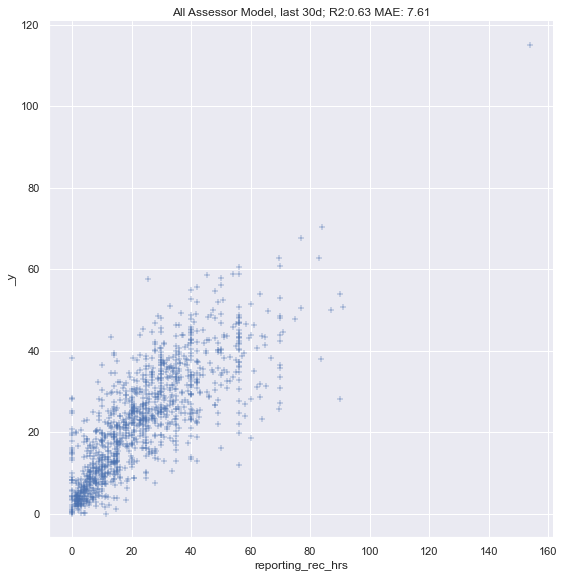

In [99]:
# preds vs rec
ax = sns.relplot(x=all_assessor_ds.y_test, y=preds, marker='+', height=8)
ax.set(title=f'All Assessor Model, last 30d; R2:{est.score(all_assessor_ds.x_test, all_assessor_ds.y_test):.02f} MAE: {np.mean(np.abs(all_assessor_ds.y_test - preds)):.02f}')

In [100]:
tdf = all_assessor_ds.test_df.assign(predicted_hours=preds, rec_minus_pred=all_assessor_ds.test_df.reporting_rec_hrs - preds)
# ax = sns.relplot(data=tdf, x='reporting_rec_hrs', y='predicted_hours', marker='+', height=8)

In [101]:
tdf.rec_minus_pred.describe()

count    1153.000000
mean        1.068659
std        10.817828
min       -38.106530
25%        -4.759227
50%        -0.481263
75%         5.657668
max        61.778590
Name: rec_minus_pred, dtype: float64

In [102]:
tdf.predicted_hours.describe()

count    1153.000000
mean       22.719008
std        13.666315
min        -0.059758
25%        11.463135
50%        22.249975
75%        32.281704
max       115.108608
Name: predicted_hours, dtype: float64

In [103]:
std_by_payer = tdf.groupby('payer_id').rec_minus_pred.std()
std_by_payer = std_by_payer.rename('payer_error_std')
std_by_payer 

payer_id
2     12.903553
4      8.610233
5      7.804565
6      9.848489
8      4.733616
9     15.298504
12    12.496291
Name: payer_error_std, dtype: float64

In [104]:
tdf = tdf.merge(std_by_payer, on='payer_id')
tdf = tdf.assign(error_std=tdf.rec_minus_pred / tdf.payer_error_std)
tdf.sort_values('error_std').head()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,glaucoma_ddos,cataract_ddos,behavioral_health_ddos,osteoporosis_ddos,hiv_ddos,transplants_ddos,obesity_ddos,cancer_ddos,hip_pelvic_fracture_ddos,sclerosis_ddos,rheumatoid_arthritis_ddos,ckd_ddos,hyperlipidemia_ddos,diabetes_ddos,hypothyroidism_ddos,pressure_ulcer_ddos,weight_loss_ddos,heart_ddos,peptic_ulcer_ddos,anemia_ddos,substance_abuse_ddos,liver_ddos,disabled_ddos,fall_ddos,stroke_ddos,paralysis_ddos,hypertension_ddos,peripheral_vascular_ddos,coagulation_ddos,fluid_ddos,benign_prostatic_hyperplasia_ddos,tbi_ddos,neurocognitive_ddos,pulmonary_ddos,glaucoma_tc,cataract_tc,behavioral_health_tc,osteoporosis_tc,hiv_tc,transplants_tc,obesity_tc,cancer_tc,hip_pelvic_fracture_tc,sclerosis_tc,rheumatoid_arthritis_tc,ckd_tc,hyperlipidemia_tc,diabetes_tc,hypothyroidism_tc,pressure_ulcer_tc,weight_loss_tc,heart_tc,peptic_ulcer_tc,anemia_tc,substance_abuse_tc,liver_tc,disabled_tc,fall_tc,stroke_tc,paralysis_tc,hypertension_tc,peripheral_vascular_tc,coagulation_tc,fluid_tc,benign_prostatic_hyperplasia_tc,tbi_tc,neurocognitive_tc,pulmonary_tc,predicted_hours,rec_minus_pred,payer_error_std,error_std
249,4,45789,549628,31076,25,23,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,False,Cindy Justice,0.0,0.00,2022-10-20 23:31:25.813244,True,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.407721,-28.407721,8.610233,-3.299298
521,6,9732,274889,29381,24,15,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,True,bladder,always_incontinent,NaN,0,0,2.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,0.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Heather Carlisle,25.5,25.50,2022-10-11 22:16:48.595202,True,82,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,20.0,14.0,1.0,0.0,7.0,0.0,2.0,0.0,9.0,0.00,0.0,24522.20,0.0,0.0,0.0,0.0,0.0,26658.28,0.00,89.18,86.87,25190.71,0.00,0.0,0.00,0.0,0.00,0.0,389.49,0.0,0.0,0.0,0.0,372.97,1168.98,1575.69,372.97,0.0,662.77,0.0,7488.0,0.0,8402.54,57.660634,-32.160634,9.848489,-3.265540
243,4,31168,974142,30989,31,24,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,1,0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Jocelyn Bertin,10.0,10.00,2022-10-18 19:57:59.267048,True,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,0.0,6.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,7.65,0.00,137.58,9315.44,0.0,12301.69,0.0,7.65,0.0,1556.00,0.0,0.0,0.0,0.0,1556.00,17135.47,137.58,0.00,0.0,3112.00,0.0,0.0,0.0,0.00,36.393685,-26.393685,8.610233,-3.065386
782,8,13067,293130,30534,23,17,2.0,0.0,2.0,3.0,3.0,1.0,3.0,3.0,True,bladder_and_bowel,always_incontinent,NaN,0,1,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Darlene Foust,12.3,2.13,2022-10-25 13:57:39.897618,True,61,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0

In [105]:
qa_sample_sfere_ids = [29549,27525,29293,31085,28569,29573,29568,29482,28044,30525,29413,29891,29009,29651,28903]
tdf = tdf.assign(is_qa_sample=tdf.sfere_id.isin(qa_sample_sfere_ids))

In [106]:
cols = ['payer_id', 'patient_id', 'analytics_member_id', 'sfere_id', 'is_qa_sample',
       'reporting_current_hrs', 'reporting_rec_hrs',
       'predicted_hours', 'rec_minus_pred', 'payer_error_std', 'error_std',
       'total_impairment_sum', 'adl_impairment_sum', 'best_in_class_assessor', 'assessor',
        'submitted_at', 'submitted_last_30d', 'age'] + features

tdf[cols].sort_values('error_std', ascending=False).to_csv('./data/recomended_hours_model_claim_20221111.csv', index=False)

In [107]:
# sns.histplot(x=tdf.predicted_hours)
# sns.histplot(x=tdf.rec_minus_pred)

In [108]:
# tdf.to_csv('./data/recomended_hours_model_alert_features_20221109.csv', index=False)
# ax.savefig('/Users/bp/Downloads/recomended_hours_model.png')
# training_df.to_csv('./data/recomended_hours_model_training_data.csv', index=False)

### Feature Importance

In [109]:
from sklearn.inspection import permutation_importance

r = permutation_importance(est, all_assessor_ds.x_test, all_assessor_ds.y_test,
                           n_repeats=30,
                           random_state=0)

In [110]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

payer_id 0.609  +/- 0.043
toileting 0.047  +/- 0.009
meal_prep 0.031  +/- 0.004
housework 0.021  +/- 0.004
eating   0.012  +/- 0.004
dressing 0.011  +/- 0.003
transportation 0.009  +/- 0.003
bathing  0.009  +/- 0.003
age      0.007  +/- 0.003
transfer_bed_to_chair 0.007  +/- 0.003
shopping 0.003  +/- 0.001
finances 0.001  +/- 0.001
turn_change_position 0.001  +/- 0.000


In [111]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

payer_id 0.609  +/- 0.043
toileting 0.047  +/- 0.009
meal_prep 0.031  +/- 0.004
housework 0.021  +/- 0.004
eating   0.012  +/- 0.004
dressing 0.011  +/- 0.003
transportation 0.009  +/- 0.003
bathing  0.009  +/- 0.003
age      0.007  +/- 0.003
transfer_bed_to_chair 0.007  +/- 0.003
shopping 0.003  +/- 0.001
finances 0.001  +/- 0.001
turn_change_position 0.001  +/- 0.000


### Tuning

In [ ]:
parameters = {
    'max_iter': [1000],
    'max_depth': [3,5,20,25],
    'min_samples_leaf': [10, 20, 50, 75, 100],
    'l2_regularization': [0, .1, .5]
}
parameters

In [ ]:
est = HistGradientBoostingRegressor(categorical_features=[0])

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

clf = HalvingGridSearchCV(est, parameters, factor=2, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

clf.best_score_, clf.best_params_